### Import libraries

In [1]:
import sys
sys.path.append("..")
from model import classic_model, combined_model, experimental_model, losses, grapher
from data import data_generation, batch_creator, gp_kernels, gp_priors
from helpers import helpers, plotter
from keras.callbacks import ModelCheckpoint
from inference import infer
import tensorflow as tf; import keras
import time

Using TensorFlow backend.


In [2]:
save_dir = '/Users/omernivron/Downloads/GPT'

In [3]:
pad_pos_tr, pad_pos_te, pad_y_fren_tr, pad_y_fren_te, _, df_te = data_generation.data_generator_for_gp_mimick_gpt(150, ordered = False, same_x = True)

In [4]:
import numpy as np

# goes with check 61
np.save('/Users/omernivron/Downloads/pad_pos_tr', pad_pos_tr)

np.save('/Users/omernivron/Downloads/pad_pos_te', pad_pos_te)

np.save('/Users/omernivron/Downloads/pad_y_fren_tr', pad_y_fren_tr)

np.save('/Users/omernivron/Downloads/pad_y_fren_te', pad_y_fren_te)

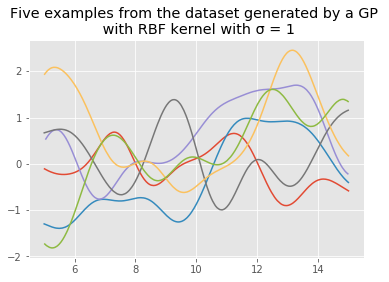

In [5]:
plotter.plot_examples(pad_pos_tr, pad_y_fren_tr)

In [6]:
train_step, test_step, loss_object, train_loss, test_loss, m_tr, m_te = grapher.build_graph()

In [7]:
batch_pos_tr, batch_tar_tr, _ = batch_creator.fake_batch(pad_pos_tr, pad_y_fren_tr, batch_s=1)
batch_pos_tr1 = batch_pos_tr[:, :-1]
batch_pos_tr_current = batch_pos_tr[:, 1:]

In [8]:
# batch_pos_tr, batch_tar_tr, _ = batch_creator.create_batch_gp_mim_2(pad_pos_tr, pad_y_fren_tr, batch_s=1)
# batch_pos_tr1 = batch_pos_tr[:, :-1]
# batch_pos_tr_current = batch_pos_tr[:, 1:]

Already exists
Restored from /Users/omernivron/Downloads/GPT/ckpt/check_2/ckpt-25
Tensor("truediv_1:0", shape=(), dtype=float64)
['decoder/wq/kernel:0', 'decoder/wq/bias:0', 'decoder/wk/kernel:0', 'decoder/wk/bias:0', 'decoder/wv/kernel:0', 'decoder/wv/bias:0', 'decoder/A2/kernel:0', 'decoder/A2/bias:0', 'decoder/A3/kernel:0', 'decoder/A3/bias:0', 'decoder/A4/kernel:0', 'decoder/A4/bias:0', 'decoder/A5/kernel:0', 'decoder/A5/bias:0']
Tensor("truediv_1:0", shape=(), dtype=float64)
['decoder/wq/kernel:0', 'decoder/wq/bias:0', 'decoder/wk/kernel:0', 'decoder/wk/bias:0', 'decoder/wv/kernel:0', 'decoder/wv/bias:0', 'decoder/A2/kernel:0', 'decoder/A2/bias:0', 'decoder/A3/kernel:0', 'decoder/A3/bias:0', 'decoder/A4/kernel:0', 'decoder/A4/bias:0', 'decoder/A5/kernel:0', 'decoder/A5/bias:0']
Tensor("truediv_1:0", shape=(), dtype=float64)


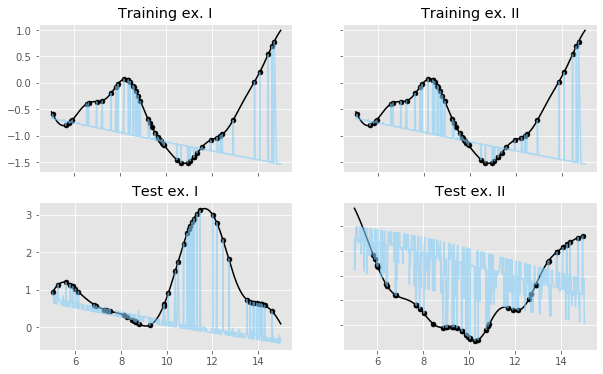

Epoch 0 batch 0 train Loss 0.3767 test Loss 0.6103 with training MSE metric 0.6884 and testing MSE metric 1.6005
tf.Tensor(b'decoder/wq/kernel:0', shape=(), dtype=string)
#############
decoder/wq/kernel:0
tf.Tensor(b'decoder/wq/bias:0', shape=(), dtype=string)
#############
decoder/wq/bias:0
tf.Tensor(b'decoder/wk/kernel:0', shape=(), dtype=string)
#############
decoder/wk/kernel:0
tf.Tensor(b'decoder/wk/bias:0', shape=(), dtype=string)
#############
decoder/wk/bias:0
tf.Tensor(b'decoder/wv/kernel:0', shape=(), dtype=string)
#############
decoder/wv/kernel:0
tf.Tensor(b'decoder/wv/bias:0', shape=(), dtype=string)
#############
decoder/wv/bias:0
tf.Tensor(b'decoder/A2/kernel:0', shape=(), dtype=string)
#############
decoder/A2/kernel:0
tf.Tensor(b'decoder/A2/bias:0', shape=(), dtype=string)
#############
decoder/A2/bias:0
tf.Tensor(b'decoder/A3/kernel:0', shape=(), dtype=string)
#############
decoder/A3/kernel:0
tf.Tensor(b'decoder/A3/bias:0', shape=(), dtype=string)
#############
decod

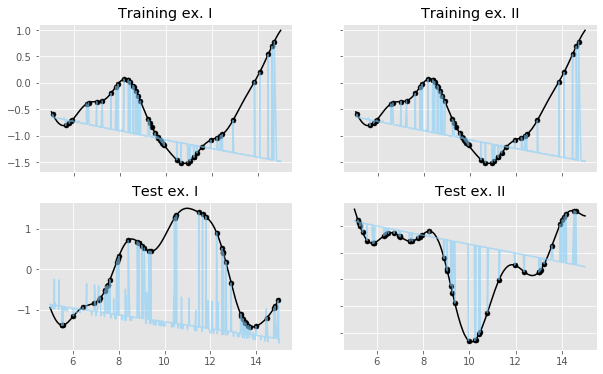

Epoch 1 batch 0 train Loss 0.3522 test Loss 0.6165 with training MSE metric 0.6459 and testing MSE metric 1.5110
tf.Tensor(b'decoder/wq/kernel:0', shape=(), dtype=string)
#############
decoder/wq/kernel:0
tf.Tensor(b'decoder/wq/bias:0', shape=(), dtype=string)
#############
decoder/wq/bias:0
tf.Tensor(b'decoder/wk/kernel:0', shape=(), dtype=string)
#############
decoder/wk/kernel:0
tf.Tensor(b'decoder/wk/bias:0', shape=(), dtype=string)
#############
decoder/wk/bias:0
tf.Tensor(b'decoder/wv/kernel:0', shape=(), dtype=string)
#############
decoder/wv/kernel:0
tf.Tensor(b'decoder/wv/bias:0', shape=(), dtype=string)
#############
decoder/wv/bias:0
tf.Tensor(b'decoder/A2/kernel:0', shape=(), dtype=string)
#############
decoder/A2/kernel:0
tf.Tensor(b'decoder/A2/bias:0', shape=(), dtype=string)
#############
decoder/A2/bias:0
tf.Tensor(b'decoder/A3/kernel:0', shape=(), dtype=string)
#############
decoder/A3/kernel:0
tf.Tensor(b'decoder/A3/bias:0', shape=(), dtype=string)
#############
decod

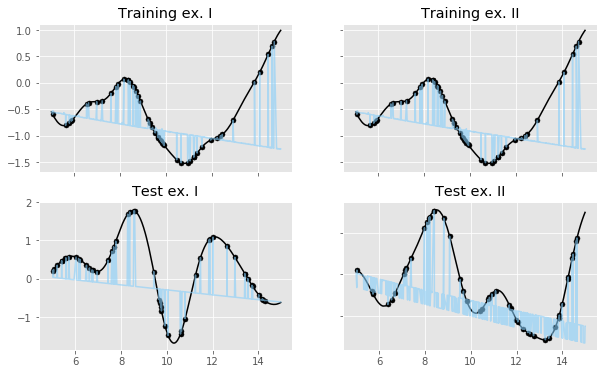

Epoch 2 batch 0 train Loss 0.2821 test Loss 0.6315 with training MSE metric 0.4967 and testing MSE metric 1.3574
tf.Tensor(b'decoder/wq/kernel:0', shape=(), dtype=string)
#############
decoder/wq/kernel:0
tf.Tensor(b'decoder/wq/bias:0', shape=(), dtype=string)
#############
decoder/wq/bias:0
tf.Tensor(b'decoder/wk/kernel:0', shape=(), dtype=string)
#############
decoder/wk/kernel:0
tf.Tensor(b'decoder/wk/bias:0', shape=(), dtype=string)
#############
decoder/wk/bias:0
tf.Tensor(b'decoder/wv/kernel:0', shape=(), dtype=string)
#############
decoder/wv/kernel:0
tf.Tensor(b'decoder/wv/bias:0', shape=(), dtype=string)
#############
decoder/wv/bias:0
tf.Tensor(b'decoder/A2/kernel:0', shape=(), dtype=string)
#############
decoder/A2/kernel:0
tf.Tensor(b'decoder/A2/bias:0', shape=(), dtype=string)
#############
decoder/A2/bias:0
tf.Tensor(b'decoder/A3/kernel:0', shape=(), dtype=string)
#############
decoder/A3/kernel:0
tf.Tensor(b'decoder/A3/bias:0', shape=(), dtype=string)
#############
decod

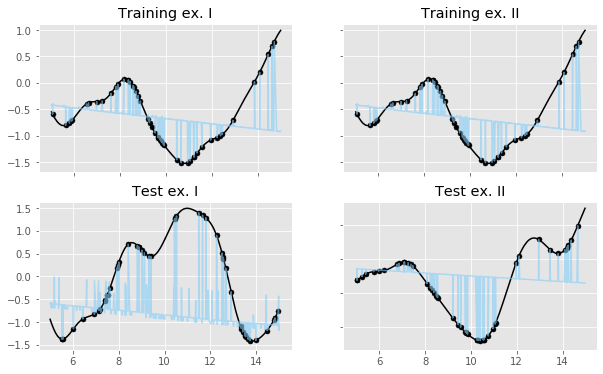

Epoch 3 batch 0 train Loss 0.2007 test Loss 0.7128 with training MSE metric 0.3748 and testing MSE metric 1.2534
tf.Tensor(b'decoder/wq/kernel:0', shape=(), dtype=string)
#############
decoder/wq/kernel:0
tf.Tensor(b'decoder/wq/bias:0', shape=(), dtype=string)
#############
decoder/wq/bias:0
tf.Tensor(b'decoder/wk/kernel:0', shape=(), dtype=string)
#############
decoder/wk/kernel:0
tf.Tensor(b'decoder/wk/bias:0', shape=(), dtype=string)
#############
decoder/wk/bias:0
tf.Tensor(b'decoder/wv/kernel:0', shape=(), dtype=string)
#############
decoder/wv/kernel:0
tf.Tensor(b'decoder/wv/bias:0', shape=(), dtype=string)
#############
decoder/wv/bias:0
tf.Tensor(b'decoder/A2/kernel:0', shape=(), dtype=string)
#############
decoder/A2/kernel:0
tf.Tensor(b'decoder/A2/bias:0', shape=(), dtype=string)
#############
decoder/A2/bias:0
tf.Tensor(b'decoder/A3/kernel:0', shape=(), dtype=string)
#############
decoder/A3/kernel:0
tf.Tensor(b'decoder/A3/bias:0', shape=(), dtype=string)
#############
decod

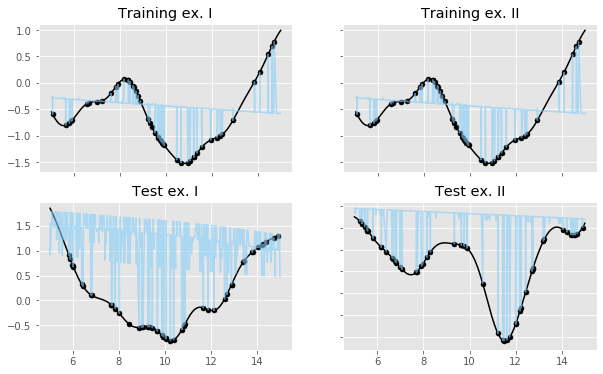

Epoch 4 batch 0 train Loss 0.1749 test Loss 0.9124 with training MSE metric 0.3688 and testing MSE metric 1.2490
tf.Tensor(b'decoder/wq/kernel:0', shape=(), dtype=string)
#############
decoder/wq/kernel:0
tf.Tensor(b'decoder/wq/bias:0', shape=(), dtype=string)
#############
decoder/wq/bias:0
tf.Tensor(b'decoder/wk/kernel:0', shape=(), dtype=string)
#############
decoder/wk/kernel:0
tf.Tensor(b'decoder/wk/bias:0', shape=(), dtype=string)
#############
decoder/wk/bias:0
tf.Tensor(b'decoder/wv/kernel:0', shape=(), dtype=string)
#############
decoder/wv/kernel:0
tf.Tensor(b'decoder/wv/bias:0', shape=(), dtype=string)
#############
decoder/wv/bias:0
tf.Tensor(b'decoder/A2/kernel:0', shape=(), dtype=string)
#############
decoder/A2/kernel:0
tf.Tensor(b'decoder/A2/bias:0', shape=(), dtype=string)
#############
decoder/A2/bias:0
tf.Tensor(b'decoder/A3/kernel:0', shape=(), dtype=string)
#############
decoder/A3/kernel:0
tf.Tensor(b'decoder/A3/bias:0', shape=(), dtype=string)
#############
decod

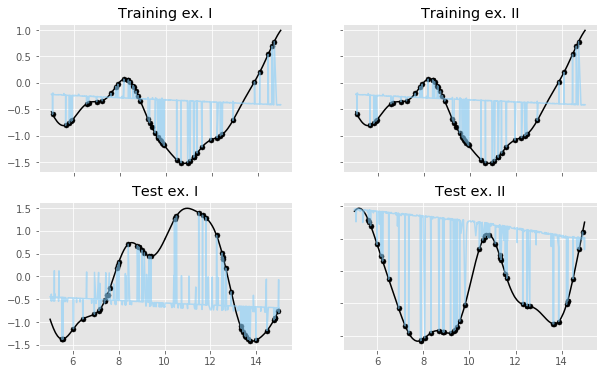

Epoch 5 batch 0 train Loss 0.2088 test Loss 1.0733 with training MSE metric 0.4066 and testing MSE metric 1.2693
tf.Tensor(b'decoder/wq/kernel:0', shape=(), dtype=string)
#############
decoder/wq/kernel:0
tf.Tensor(b'decoder/wq/bias:0', shape=(), dtype=string)
#############
decoder/wq/bias:0
tf.Tensor(b'decoder/wk/kernel:0', shape=(), dtype=string)
#############
decoder/wk/kernel:0
tf.Tensor(b'decoder/wk/bias:0', shape=(), dtype=string)
#############
decoder/wk/bias:0
tf.Tensor(b'decoder/wv/kernel:0', shape=(), dtype=string)
#############
decoder/wv/kernel:0
tf.Tensor(b'decoder/wv/bias:0', shape=(), dtype=string)
#############
decoder/wv/bias:0
tf.Tensor(b'decoder/A2/kernel:0', shape=(), dtype=string)
#############
decoder/A2/kernel:0
tf.Tensor(b'decoder/A2/bias:0', shape=(), dtype=string)
#############
decoder/A2/bias:0
tf.Tensor(b'decoder/A3/kernel:0', shape=(), dtype=string)
#############
decoder/A3/kernel:0
tf.Tensor(b'decoder/A3/bias:0', shape=(), dtype=string)
#############
decod

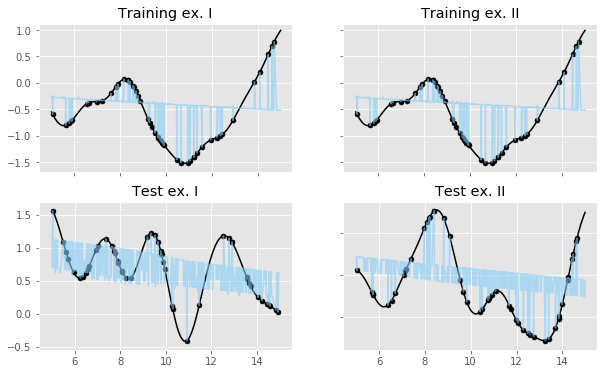

Epoch 6 batch 0 train Loss 0.1854 test Loss 1.0494 with training MSE metric 0.3765 and testing MSE metric 1.2695
tf.Tensor(b'decoder/wq/kernel:0', shape=(), dtype=string)
#############
decoder/wq/kernel:0
tf.Tensor(b'decoder/wq/bias:0', shape=(), dtype=string)
#############
decoder/wq/bias:0
tf.Tensor(b'decoder/wk/kernel:0', shape=(), dtype=string)
#############
decoder/wk/kernel:0
tf.Tensor(b'decoder/wk/bias:0', shape=(), dtype=string)
#############
decoder/wk/bias:0
tf.Tensor(b'decoder/wv/kernel:0', shape=(), dtype=string)
#############
decoder/wv/kernel:0
tf.Tensor(b'decoder/wv/bias:0', shape=(), dtype=string)
#############
decoder/wv/bias:0
tf.Tensor(b'decoder/A2/kernel:0', shape=(), dtype=string)
#############
decoder/A2/kernel:0
tf.Tensor(b'decoder/A2/bias:0', shape=(), dtype=string)
#############
decoder/A2/bias:0
tf.Tensor(b'decoder/A3/kernel:0', shape=(), dtype=string)
#############
decoder/A3/kernel:0
tf.Tensor(b'decoder/A3/bias:0', shape=(), dtype=string)
#############
decod

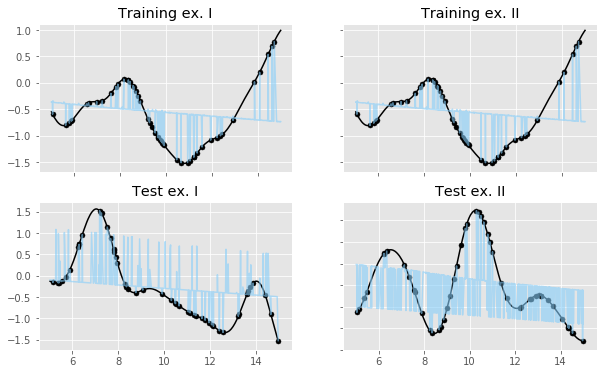

Epoch 7 batch 0 train Loss 0.1646 test Loss 0.9990 with training MSE metric 0.3540 and testing MSE metric 1.2953
tf.Tensor(b'decoder/wq/kernel:0', shape=(), dtype=string)
#############
decoder/wq/kernel:0
tf.Tensor(b'decoder/wq/bias:0', shape=(), dtype=string)
#############
decoder/wq/bias:0
tf.Tensor(b'decoder/wk/kernel:0', shape=(), dtype=string)
#############
decoder/wk/kernel:0
tf.Tensor(b'decoder/wk/bias:0', shape=(), dtype=string)
#############
decoder/wk/bias:0
tf.Tensor(b'decoder/wv/kernel:0', shape=(), dtype=string)
#############
decoder/wv/kernel:0
tf.Tensor(b'decoder/wv/bias:0', shape=(), dtype=string)
#############
decoder/wv/bias:0
tf.Tensor(b'decoder/A2/kernel:0', shape=(), dtype=string)
#############
decoder/A2/kernel:0
tf.Tensor(b'decoder/A2/bias:0', shape=(), dtype=string)
#############
decoder/A2/bias:0
tf.Tensor(b'decoder/A3/kernel:0', shape=(), dtype=string)
#############
decoder/A3/kernel:0
tf.Tensor(b'decoder/A3/bias:0', shape=(), dtype=string)
#############
decod

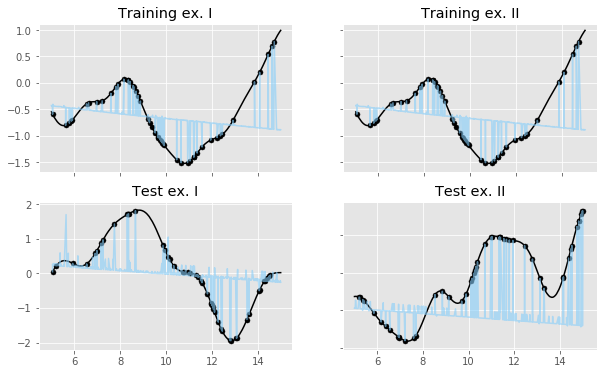

Epoch 8 batch 0 train Loss 0.1747 test Loss 0.9900 with training MSE metric 0.3690 and testing MSE metric 1.3286
tf.Tensor(b'decoder/wq/kernel:0', shape=(), dtype=string)
#############
decoder/wq/kernel:0
tf.Tensor(b'decoder/wq/bias:0', shape=(), dtype=string)
#############
decoder/wq/bias:0
tf.Tensor(b'decoder/wk/kernel:0', shape=(), dtype=string)
#############
decoder/wk/kernel:0
tf.Tensor(b'decoder/wk/bias:0', shape=(), dtype=string)
#############
decoder/wk/bias:0
tf.Tensor(b'decoder/wv/kernel:0', shape=(), dtype=string)
#############
decoder/wv/kernel:0
tf.Tensor(b'decoder/wv/bias:0', shape=(), dtype=string)
#############
decoder/wv/bias:0
tf.Tensor(b'decoder/A2/kernel:0', shape=(), dtype=string)
#############
decoder/A2/kernel:0
tf.Tensor(b'decoder/A2/bias:0', shape=(), dtype=string)
#############
decoder/A2/bias:0
tf.Tensor(b'decoder/A3/kernel:0', shape=(), dtype=string)
#############
decoder/A3/kernel:0
tf.Tensor(b'decoder/A3/bias:0', shape=(), dtype=string)
#############
decod

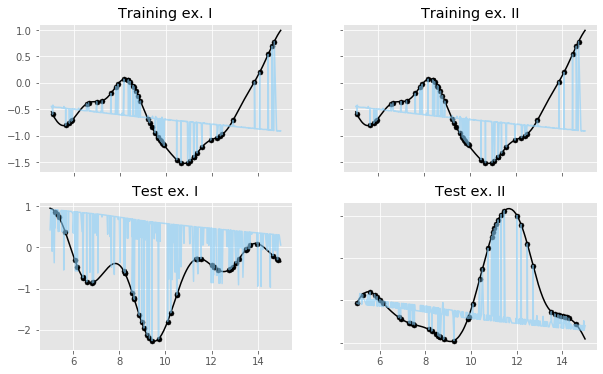

Epoch 9 batch 0 train Loss 0.1774 test Loss 1.0087 with training MSE metric 0.3730 and testing MSE metric 1.3375
tf.Tensor(b'decoder/wq/kernel:0', shape=(), dtype=string)
#############
decoder/wq/kernel:0
tf.Tensor(b'decoder/wq/bias:0', shape=(), dtype=string)
#############
decoder/wq/bias:0
tf.Tensor(b'decoder/wk/kernel:0', shape=(), dtype=string)
#############
decoder/wk/kernel:0
tf.Tensor(b'decoder/wk/bias:0', shape=(), dtype=string)
#############
decoder/wk/bias:0
tf.Tensor(b'decoder/wv/kernel:0', shape=(), dtype=string)
#############
decoder/wv/kernel:0
tf.Tensor(b'decoder/wv/bias:0', shape=(), dtype=string)
#############
decoder/wv/bias:0
tf.Tensor(b'decoder/A2/kernel:0', shape=(), dtype=string)
#############
decoder/A2/kernel:0
tf.Tensor(b'decoder/A2/bias:0', shape=(), dtype=string)
#############
decoder/A2/bias:0
tf.Tensor(b'decoder/A3/kernel:0', shape=(), dtype=string)
#############
decoder/A3/kernel:0
tf.Tensor(b'decoder/A3/bias:0', shape=(), dtype=string)
#############
decod

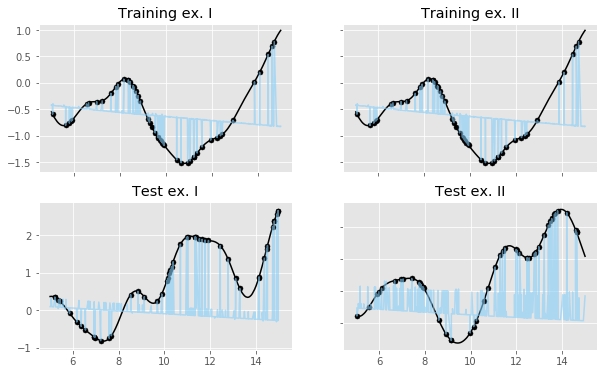

Epoch 10 batch 0 train Loss 0.1677 test Loss 1.0529 with training MSE metric 0.3584 and testing MSE metric 1.3342
tf.Tensor(b'decoder/wq/kernel:0', shape=(), dtype=string)
#############
decoder/wq/kernel:0
tf.Tensor(b'decoder/wq/bias:0', shape=(), dtype=string)
#############
decoder/wq/bias:0
tf.Tensor(b'decoder/wk/kernel:0', shape=(), dtype=string)
#############
decoder/wk/kernel:0
tf.Tensor(b'decoder/wk/bias:0', shape=(), dtype=string)
#############
decoder/wk/bias:0
tf.Tensor(b'decoder/wv/kernel:0', shape=(), dtype=string)
#############
decoder/wv/kernel:0
tf.Tensor(b'decoder/wv/bias:0', shape=(), dtype=string)
#############
decoder/wv/bias:0
tf.Tensor(b'decoder/A2/kernel:0', shape=(), dtype=string)
#############
decoder/A2/kernel:0
tf.Tensor(b'decoder/A2/bias:0', shape=(), dtype=string)
#############
decoder/A2/bias:0
tf.Tensor(b'decoder/A3/kernel:0', shape=(), dtype=string)
#############
decoder/A3/kernel:0
tf.Tensor(b'decoder/A3/bias:0', shape=(), dtype=string)
#############
deco

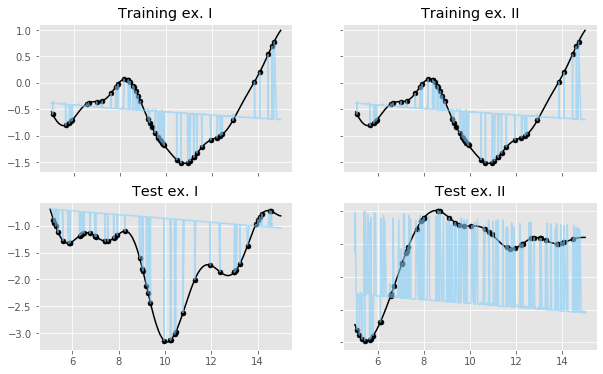

Epoch 11 batch 0 train Loss 0.1615 test Loss 1.1152 with training MSE metric 0.3494 and testing MSE metric 1.3416
tf.Tensor(b'decoder/wq/kernel:0', shape=(), dtype=string)
#############
decoder/wq/kernel:0
tf.Tensor(b'decoder/wq/bias:0', shape=(), dtype=string)
#############
decoder/wq/bias:0
tf.Tensor(b'decoder/wk/kernel:0', shape=(), dtype=string)
#############
decoder/wk/kernel:0
tf.Tensor(b'decoder/wk/bias:0', shape=(), dtype=string)
#############
decoder/wk/bias:0
tf.Tensor(b'decoder/wv/kernel:0', shape=(), dtype=string)
#############
decoder/wv/kernel:0
tf.Tensor(b'decoder/wv/bias:0', shape=(), dtype=string)
#############
decoder/wv/bias:0
tf.Tensor(b'decoder/A2/kernel:0', shape=(), dtype=string)
#############
decoder/A2/kernel:0
tf.Tensor(b'decoder/A2/bias:0', shape=(), dtype=string)
#############
decoder/A2/bias:0
tf.Tensor(b'decoder/A3/kernel:0', shape=(), dtype=string)
#############
decoder/A3/kernel:0
tf.Tensor(b'decoder/A3/bias:0', shape=(), dtype=string)
#############
deco

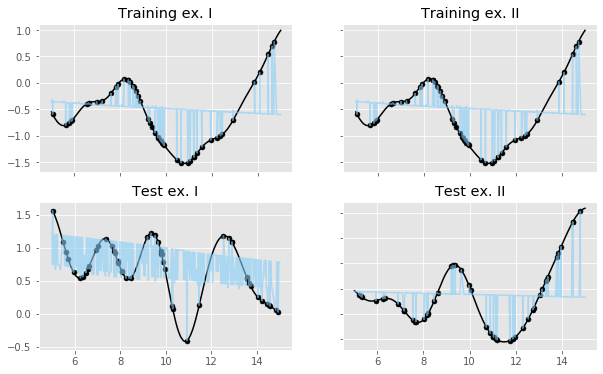

Epoch 12 batch 0 train Loss 0.1641 test Loss 1.1569 with training MSE metric 0.3522 and testing MSE metric 1.3588
tf.Tensor(b'decoder/wq/kernel:0', shape=(), dtype=string)
#############
decoder/wq/kernel:0
tf.Tensor(b'decoder/wq/bias:0', shape=(), dtype=string)
#############
decoder/wq/bias:0
tf.Tensor(b'decoder/wk/kernel:0', shape=(), dtype=string)
#############
decoder/wk/kernel:0
tf.Tensor(b'decoder/wk/bias:0', shape=(), dtype=string)
#############
decoder/wk/bias:0
tf.Tensor(b'decoder/wv/kernel:0', shape=(), dtype=string)
#############
decoder/wv/kernel:0
tf.Tensor(b'decoder/wv/bias:0', shape=(), dtype=string)
#############
decoder/wv/bias:0
tf.Tensor(b'decoder/A2/kernel:0', shape=(), dtype=string)
#############
decoder/A2/kernel:0
tf.Tensor(b'decoder/A2/bias:0', shape=(), dtype=string)
#############
decoder/A2/bias:0
tf.Tensor(b'decoder/A3/kernel:0', shape=(), dtype=string)
#############
decoder/A3/kernel:0
tf.Tensor(b'decoder/A3/bias:0', shape=(), dtype=string)
#############
deco

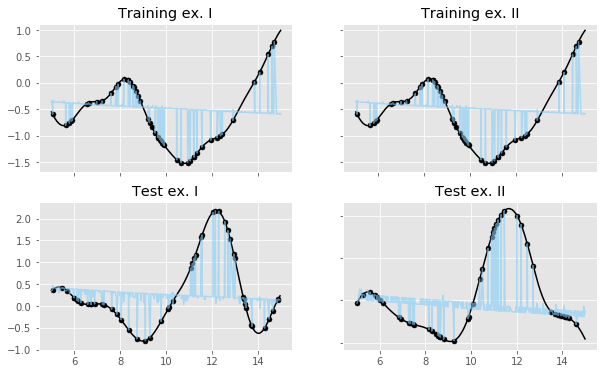

Epoch 13 batch 0 train Loss 0.1636 test Loss 1.1501 with training MSE metric 0.3517 and testing MSE metric 1.3743
tf.Tensor(b'decoder/wq/kernel:0', shape=(), dtype=string)
#############
decoder/wq/kernel:0
tf.Tensor(b'decoder/wq/bias:0', shape=(), dtype=string)
#############
decoder/wq/bias:0
tf.Tensor(b'decoder/wk/kernel:0', shape=(), dtype=string)
#############
decoder/wk/kernel:0
tf.Tensor(b'decoder/wk/bias:0', shape=(), dtype=string)
#############
decoder/wk/bias:0
tf.Tensor(b'decoder/wv/kernel:0', shape=(), dtype=string)
#############
decoder/wv/kernel:0
tf.Tensor(b'decoder/wv/bias:0', shape=(), dtype=string)
#############
decoder/wv/bias:0
tf.Tensor(b'decoder/A2/kernel:0', shape=(), dtype=string)
#############
decoder/A2/kernel:0
tf.Tensor(b'decoder/A2/bias:0', shape=(), dtype=string)
#############
decoder/A2/bias:0
tf.Tensor(b'decoder/A3/kernel:0', shape=(), dtype=string)
#############
decoder/A3/kernel:0
tf.Tensor(b'decoder/A3/bias:0', shape=(), dtype=string)
#############
deco

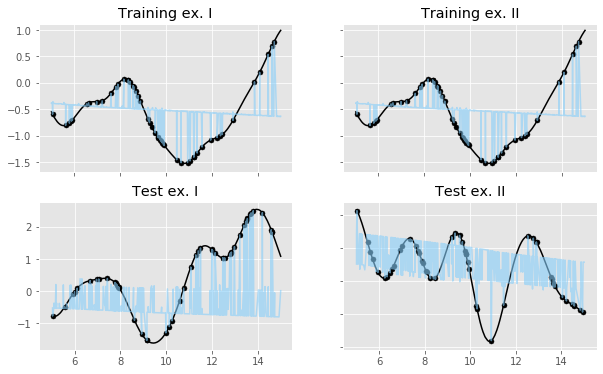

Epoch 14 batch 0 train Loss 0.1598 test Loss 1.1231 with training MSE metric 0.3468 and testing MSE metric 1.3889
tf.Tensor(b'decoder/wq/kernel:0', shape=(), dtype=string)
#############
decoder/wq/kernel:0
tf.Tensor(b'decoder/wq/bias:0', shape=(), dtype=string)
#############
decoder/wq/bias:0
tf.Tensor(b'decoder/wk/kernel:0', shape=(), dtype=string)
#############
decoder/wk/kernel:0
tf.Tensor(b'decoder/wk/bias:0', shape=(), dtype=string)
#############
decoder/wk/bias:0
tf.Tensor(b'decoder/wv/kernel:0', shape=(), dtype=string)
#############
decoder/wv/kernel:0
tf.Tensor(b'decoder/wv/bias:0', shape=(), dtype=string)
#############
decoder/wv/bias:0
tf.Tensor(b'decoder/A2/kernel:0', shape=(), dtype=string)
#############
decoder/A2/kernel:0
tf.Tensor(b'decoder/A2/bias:0', shape=(), dtype=string)
#############
decoder/A2/bias:0
tf.Tensor(b'decoder/A3/kernel:0', shape=(), dtype=string)
#############
decoder/A3/kernel:0
tf.Tensor(b'decoder/A3/bias:0', shape=(), dtype=string)
#############
deco

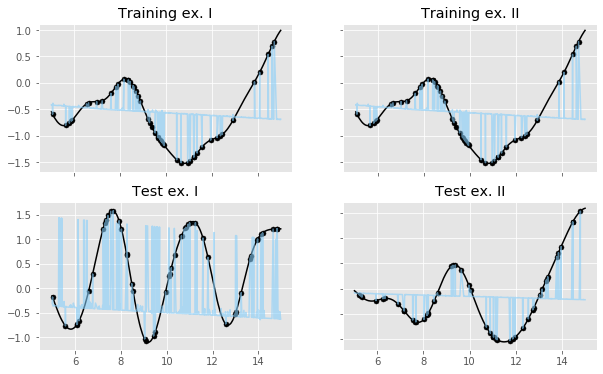

Epoch 15 batch 0 train Loss 0.1592 test Loss 1.1130 with training MSE metric 0.3451 and testing MSE metric 1.4047
tf.Tensor(b'decoder/wq/kernel:0', shape=(), dtype=string)
#############
decoder/wq/kernel:0
tf.Tensor(b'decoder/wq/bias:0', shape=(), dtype=string)
#############
decoder/wq/bias:0
tf.Tensor(b'decoder/wk/kernel:0', shape=(), dtype=string)
#############
decoder/wk/kernel:0
tf.Tensor(b'decoder/wk/bias:0', shape=(), dtype=string)
#############
decoder/wk/bias:0
tf.Tensor(b'decoder/wv/kernel:0', shape=(), dtype=string)
#############
decoder/wv/kernel:0
tf.Tensor(b'decoder/wv/bias:0', shape=(), dtype=string)
#############
decoder/wv/bias:0
tf.Tensor(b'decoder/A2/kernel:0', shape=(), dtype=string)
#############
decoder/A2/kernel:0
tf.Tensor(b'decoder/A2/bias:0', shape=(), dtype=string)
#############
decoder/A2/bias:0
tf.Tensor(b'decoder/A3/kernel:0', shape=(), dtype=string)
#############
decoder/A3/kernel:0
tf.Tensor(b'decoder/A3/bias:0', shape=(), dtype=string)
#############
deco

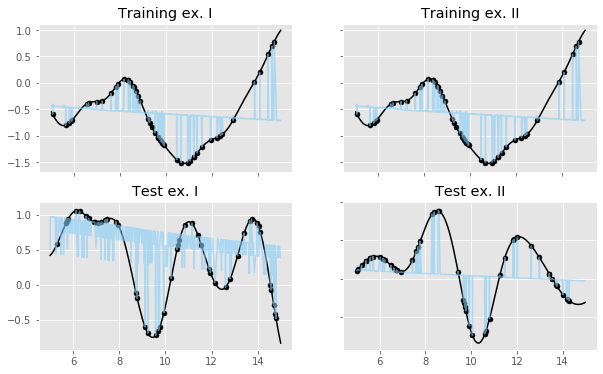

Epoch 16 batch 0 train Loss 0.1594 test Loss 1.1324 with training MSE metric 0.3450 and testing MSE metric 1.4190
tf.Tensor(b'decoder/wq/kernel:0', shape=(), dtype=string)
#############
decoder/wq/kernel:0
tf.Tensor(b'decoder/wq/bias:0', shape=(), dtype=string)
#############
decoder/wq/bias:0
tf.Tensor(b'decoder/wk/kernel:0', shape=(), dtype=string)
#############
decoder/wk/kernel:0
tf.Tensor(b'decoder/wk/bias:0', shape=(), dtype=string)
#############
decoder/wk/bias:0
tf.Tensor(b'decoder/wv/kernel:0', shape=(), dtype=string)
#############
decoder/wv/kernel:0
tf.Tensor(b'decoder/wv/bias:0', shape=(), dtype=string)
#############
decoder/wv/bias:0
tf.Tensor(b'decoder/A2/kernel:0', shape=(), dtype=string)
#############
decoder/A2/kernel:0
tf.Tensor(b'decoder/A2/bias:0', shape=(), dtype=string)
#############
decoder/A2/bias:0
tf.Tensor(b'decoder/A3/kernel:0', shape=(), dtype=string)
#############
decoder/A3/kernel:0
tf.Tensor(b'decoder/A3/bias:0', shape=(), dtype=string)
#############
deco

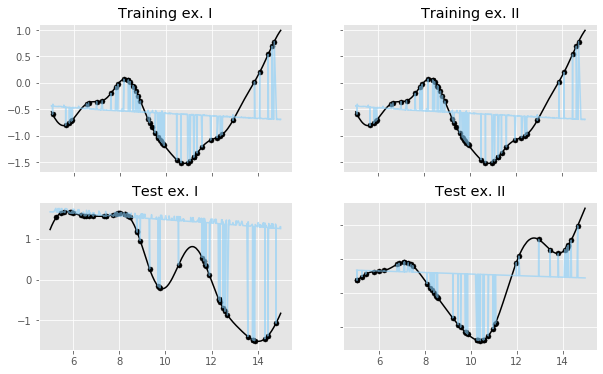

Epoch 17 batch 0 train Loss 0.1580 test Loss 1.1771 with training MSE metric 0.3434 and testing MSE metric 1.4317
tf.Tensor(b'decoder/wq/kernel:0', shape=(), dtype=string)
#############
decoder/wq/kernel:0
tf.Tensor(b'decoder/wq/bias:0', shape=(), dtype=string)
#############
decoder/wq/bias:0
tf.Tensor(b'decoder/wk/kernel:0', shape=(), dtype=string)
#############
decoder/wk/kernel:0
tf.Tensor(b'decoder/wk/bias:0', shape=(), dtype=string)
#############
decoder/wk/bias:0
tf.Tensor(b'decoder/wv/kernel:0', shape=(), dtype=string)
#############
decoder/wv/kernel:0
tf.Tensor(b'decoder/wv/bias:0', shape=(), dtype=string)
#############
decoder/wv/bias:0
tf.Tensor(b'decoder/A2/kernel:0', shape=(), dtype=string)
#############
decoder/A2/kernel:0
tf.Tensor(b'decoder/A2/bias:0', shape=(), dtype=string)
#############
decoder/A2/bias:0
tf.Tensor(b'decoder/A3/kernel:0', shape=(), dtype=string)
#############
decoder/A3/kernel:0
tf.Tensor(b'decoder/A3/bias:0', shape=(), dtype=string)
#############
deco

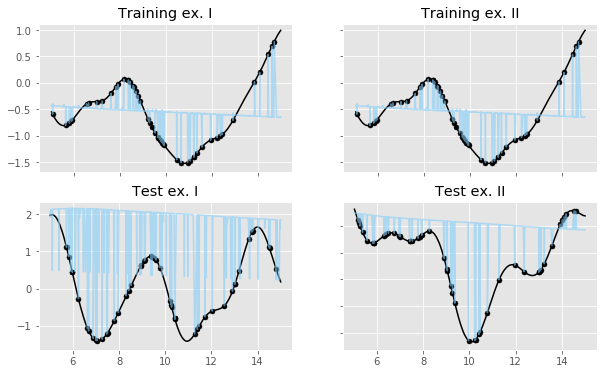

Epoch 18 batch 0 train Loss 0.1565 test Loss 1.2331 with training MSE metric 0.3418 and testing MSE metric 1.4453
tf.Tensor(b'decoder/wq/kernel:0', shape=(), dtype=string)
#############
decoder/wq/kernel:0
tf.Tensor(b'decoder/wq/bias:0', shape=(), dtype=string)
#############
decoder/wq/bias:0
tf.Tensor(b'decoder/wk/kernel:0', shape=(), dtype=string)
#############
decoder/wk/kernel:0
tf.Tensor(b'decoder/wk/bias:0', shape=(), dtype=string)
#############
decoder/wk/bias:0
tf.Tensor(b'decoder/wv/kernel:0', shape=(), dtype=string)
#############
decoder/wv/kernel:0
tf.Tensor(b'decoder/wv/bias:0', shape=(), dtype=string)
#############
decoder/wv/bias:0
tf.Tensor(b'decoder/A2/kernel:0', shape=(), dtype=string)
#############
decoder/A2/kernel:0
tf.Tensor(b'decoder/A2/bias:0', shape=(), dtype=string)
#############
decoder/A2/bias:0
tf.Tensor(b'decoder/A3/kernel:0', shape=(), dtype=string)
#############
decoder/A3/kernel:0
tf.Tensor(b'decoder/A3/bias:0', shape=(), dtype=string)
#############
deco

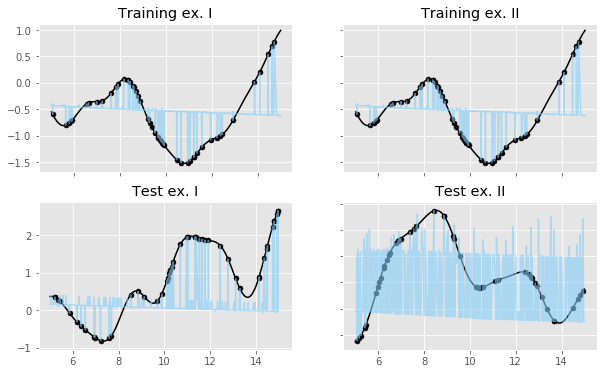

Epoch 19 batch 0 train Loss 0.1562 test Loss 1.2795 with training MSE metric 0.3413 and testing MSE metric 1.4599
tf.Tensor(b'decoder/wq/kernel:0', shape=(), dtype=string)
#############
decoder/wq/kernel:0
tf.Tensor(b'decoder/wq/bias:0', shape=(), dtype=string)
#############
decoder/wq/bias:0
tf.Tensor(b'decoder/wk/kernel:0', shape=(), dtype=string)
#############
decoder/wk/kernel:0
tf.Tensor(b'decoder/wk/bias:0', shape=(), dtype=string)
#############
decoder/wk/bias:0
tf.Tensor(b'decoder/wv/kernel:0', shape=(), dtype=string)
#############
decoder/wv/kernel:0
tf.Tensor(b'decoder/wv/bias:0', shape=(), dtype=string)
#############
decoder/wv/bias:0
tf.Tensor(b'decoder/A2/kernel:0', shape=(), dtype=string)
#############
decoder/A2/kernel:0
tf.Tensor(b'decoder/A2/bias:0', shape=(), dtype=string)
#############
decoder/A2/bias:0
tf.Tensor(b'decoder/A3/kernel:0', shape=(), dtype=string)
#############
decoder/A3/kernel:0
tf.Tensor(b'decoder/A3/bias:0', shape=(), dtype=string)
#############
deco

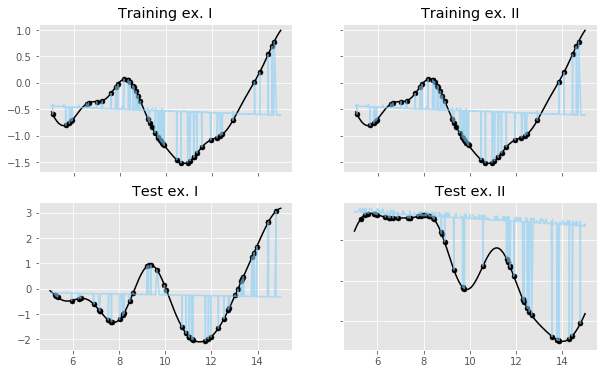

Epoch 20 batch 0 train Loss 0.1556 test Loss 1.3033 with training MSE metric 0.3404 and testing MSE metric 1.4742
tf.Tensor(b'decoder/wq/kernel:0', shape=(), dtype=string)
#############
decoder/wq/kernel:0
tf.Tensor(b'decoder/wq/bias:0', shape=(), dtype=string)
#############
decoder/wq/bias:0
tf.Tensor(b'decoder/wk/kernel:0', shape=(), dtype=string)
#############
decoder/wk/kernel:0
tf.Tensor(b'decoder/wk/bias:0', shape=(), dtype=string)
#############
decoder/wk/bias:0
tf.Tensor(b'decoder/wv/kernel:0', shape=(), dtype=string)
#############
decoder/wv/kernel:0
tf.Tensor(b'decoder/wv/bias:0', shape=(), dtype=string)
#############
decoder/wv/bias:0
tf.Tensor(b'decoder/A2/kernel:0', shape=(), dtype=string)
#############
decoder/A2/kernel:0
tf.Tensor(b'decoder/A2/bias:0', shape=(), dtype=string)
#############
decoder/A2/bias:0
tf.Tensor(b'decoder/A3/kernel:0', shape=(), dtype=string)
#############
decoder/A3/kernel:0
tf.Tensor(b'decoder/A3/bias:0', shape=(), dtype=string)
#############
deco

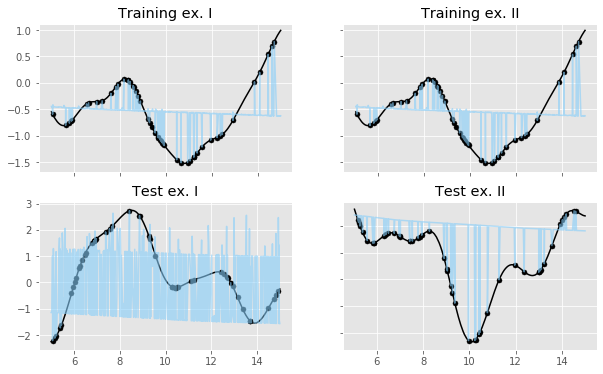

Epoch 21 batch 0 train Loss 0.1546 test Loss 1.3111 with training MSE metric 0.3390 and testing MSE metric 1.4886
tf.Tensor(b'decoder/wq/kernel:0', shape=(), dtype=string)
#############
decoder/wq/kernel:0
tf.Tensor(b'decoder/wq/bias:0', shape=(), dtype=string)
#############
decoder/wq/bias:0
tf.Tensor(b'decoder/wk/kernel:0', shape=(), dtype=string)
#############
decoder/wk/kernel:0
tf.Tensor(b'decoder/wk/bias:0', shape=(), dtype=string)
#############
decoder/wk/bias:0
tf.Tensor(b'decoder/wv/kernel:0', shape=(), dtype=string)
#############
decoder/wv/kernel:0
tf.Tensor(b'decoder/wv/bias:0', shape=(), dtype=string)
#############
decoder/wv/bias:0
tf.Tensor(b'decoder/A2/kernel:0', shape=(), dtype=string)
#############
decoder/A2/kernel:0
tf.Tensor(b'decoder/A2/bias:0', shape=(), dtype=string)
#############
decoder/A2/bias:0
tf.Tensor(b'decoder/A3/kernel:0', shape=(), dtype=string)
#############
decoder/A3/kernel:0
tf.Tensor(b'decoder/A3/bias:0', shape=(), dtype=string)
#############
deco

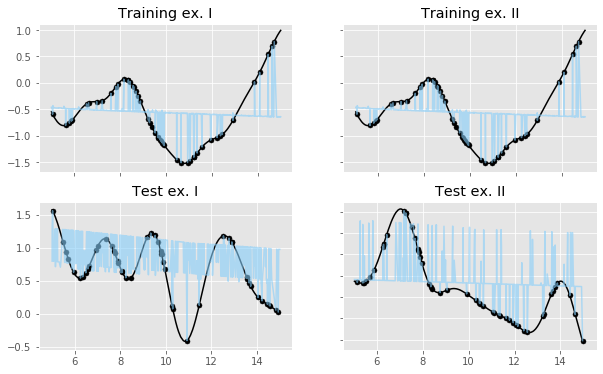

Epoch 22 batch 0 train Loss 0.1541 test Loss 1.3188 with training MSE metric 0.3381 and testing MSE metric 1.5037
tf.Tensor(b'decoder/wq/kernel:0', shape=(), dtype=string)
#############
decoder/wq/kernel:0
tf.Tensor(b'decoder/wq/bias:0', shape=(), dtype=string)
#############
decoder/wq/bias:0
tf.Tensor(b'decoder/wk/kernel:0', shape=(), dtype=string)
#############
decoder/wk/kernel:0
tf.Tensor(b'decoder/wk/bias:0', shape=(), dtype=string)
#############
decoder/wk/bias:0
tf.Tensor(b'decoder/wv/kernel:0', shape=(), dtype=string)
#############
decoder/wv/kernel:0
tf.Tensor(b'decoder/wv/bias:0', shape=(), dtype=string)
#############
decoder/wv/bias:0
tf.Tensor(b'decoder/A2/kernel:0', shape=(), dtype=string)
#############
decoder/A2/kernel:0
tf.Tensor(b'decoder/A2/bias:0', shape=(), dtype=string)
#############
decoder/A2/bias:0
tf.Tensor(b'decoder/A3/kernel:0', shape=(), dtype=string)
#############
decoder/A3/kernel:0
tf.Tensor(b'decoder/A3/bias:0', shape=(), dtype=string)
#############
deco

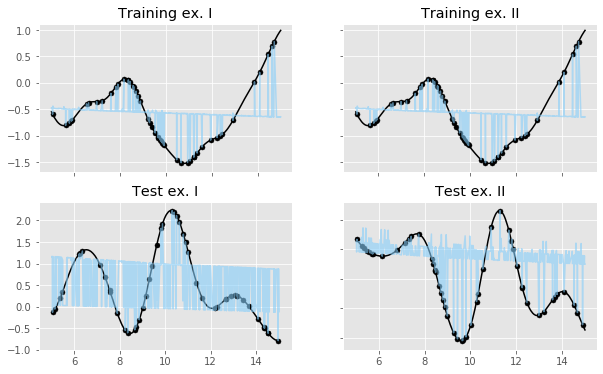

Epoch 23 batch 0 train Loss 0.1536 test Loss 1.3360 with training MSE metric 0.3374 and testing MSE metric 1.5193
tf.Tensor(b'decoder/wq/kernel:0', shape=(), dtype=string)
#############
decoder/wq/kernel:0
tf.Tensor(b'decoder/wq/bias:0', shape=(), dtype=string)
#############
decoder/wq/bias:0
tf.Tensor(b'decoder/wk/kernel:0', shape=(), dtype=string)
#############
decoder/wk/kernel:0
tf.Tensor(b'decoder/wk/bias:0', shape=(), dtype=string)
#############
decoder/wk/bias:0
tf.Tensor(b'decoder/wv/kernel:0', shape=(), dtype=string)
#############
decoder/wv/kernel:0
tf.Tensor(b'decoder/wv/bias:0', shape=(), dtype=string)
#############
decoder/wv/bias:0
tf.Tensor(b'decoder/A2/kernel:0', shape=(), dtype=string)
#############
decoder/A2/kernel:0
tf.Tensor(b'decoder/A2/bias:0', shape=(), dtype=string)
#############
decoder/A2/bias:0
tf.Tensor(b'decoder/A3/kernel:0', shape=(), dtype=string)
#############
decoder/A3/kernel:0
tf.Tensor(b'decoder/A3/bias:0', shape=(), dtype=string)
#############
deco

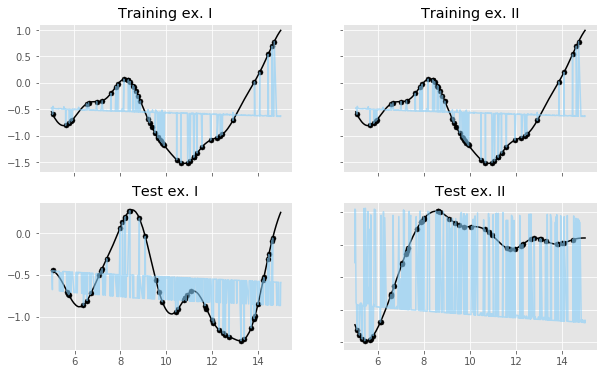

Epoch 24 batch 0 train Loss 0.1529 test Loss 1.3620 with training MSE metric 0.3365 and testing MSE metric 1.5355
tf.Tensor(b'decoder/wq/kernel:0', shape=(), dtype=string)
#############
decoder/wq/kernel:0
tf.Tensor(b'decoder/wq/bias:0', shape=(), dtype=string)
#############
decoder/wq/bias:0
tf.Tensor(b'decoder/wk/kernel:0', shape=(), dtype=string)
#############
decoder/wk/kernel:0
tf.Tensor(b'decoder/wk/bias:0', shape=(), dtype=string)
#############
decoder/wk/bias:0
tf.Tensor(b'decoder/wv/kernel:0', shape=(), dtype=string)
#############
decoder/wv/kernel:0
tf.Tensor(b'decoder/wv/bias:0', shape=(), dtype=string)
#############
decoder/wv/bias:0
tf.Tensor(b'decoder/A2/kernel:0', shape=(), dtype=string)
#############
decoder/A2/kernel:0
tf.Tensor(b'decoder/A2/bias:0', shape=(), dtype=string)
#############
decoder/A2/bias:0
tf.Tensor(b'decoder/A3/kernel:0', shape=(), dtype=string)
#############
decoder/A3/kernel:0
tf.Tensor(b'decoder/A3/bias:0', shape=(), dtype=string)
#############
deco

In [9]:
if __name__ == '__main__':
    writer = tf.summary.create_file_writer(save_dir + '/logs/')
    optimizer_c = tf.keras.optimizers.Adam(3e-4)
    decoder = experimental_model.Decoder(256); tf.random.set_seed(443)   
    EPOCHS = 25; batch_s  = 32; run = 2; step = 0
    num_batches = int(pad_y_fren_tr.shape[0] / batch_s)
#     num_batches = 1500
    ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer = optimizer_c, net = decoder)
    main_folder = "/Users/omernivron/Downloads/GPT/ckpt/check_"
    folder = main_folder + str(run); helpers.mkdir(folder)
    manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=3)
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")
    
    with writer.as_default():
        for epoch in range(EPOCHS):

            start = time.time()

            for batch_n in range(num_batches):
                m_tr.reset_states(); train_loss.reset_states()
                m_te.reset_states(); test_loss.reset_states()
#                 batch_pos_tr, batch_tar_tr, _ = batch_creator.create_batch_gp_mim_2(pad_pos_tr, pad_y_fren_tr, batch_s=64)
#                 batch_pos_tr1 = batch_pos_tr[:, :-1]
#                 batch_pos_tr_current = batch_pos_tr[:, 1:]
                pred, pred_log, weights, names = train_step(decoder, optimizer_c, train_loss, m_tr, batch_pos_tr1, batch_pos_tr_current, batch_tar_tr)
                
                if batch_n % 1500 == 0:
#                     plotter.sample_plot_w_training(batch_pos_tr_current[1, :], batch_tar_tr[1, 1:], pred[1, :], title = 'training progress')
                    pos_te1 = pad_pos_te[:, :-1]
                    pos_te_current = pad_pos_te[:, 1:]
                    pred_te, pred_log_te = test_step(decoder, test_loss, m_te, pos_te1[:500, :], pos_te_current[:500, :], pad_y_fren_te[:500, :])
                    plotter.follow_training_plot(batch_pos_tr_current, batch_tar_tr[:, 1:], pred, pos_te_current[:500, :], pad_y_fren_te[:500, 1:], pred_te)
                    helpers.print_progress(epoch, batch_n, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result())
                    helpers.tf_summaries(run, step, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result(), weights, names)
                    manager.save()
                step += 1
                ckpt.step.assign_add(1)

            print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

In [ ]:
var